<a href="https://colab.research.google.com/github/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/1km%E3%83%A1%E3%83%83%E3%82%B7%E3%83%A5%E6%B0%97%E8%B1%A1%E6%83%85%E5%A0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#農研機構 メッシュ農業気象データシステムの使い方

観測・計算方法についての論文

[実況値と数値予報，平年値を組み合わせたメッシュ気温・降水量データの作成](https://www.jstage.jst.go.jp/article/cib/16/0/16_J-16-028/_article/-char/ja/)

In [1]:
#@title 利用登録時に申請したIDとパスワードを入力
# ライブラリ（メッシュデータ処理のために必要）
!pip install -q netCDF4
!pip install -q japanize-matplotlib
import numpy as np
import os
import sys
import shutil
from google.colab import userdata
import japanize_matplotlib
japanize_matplotlib.japanize()

ID = '' # @param {type:"string"}
passward = '' # @param {type:"string"}
if ID == '':
  ID= userdata.get("ID")
  passward= userdata.get("passward")

if os.path.exists('/content/AMGSDS_map.html'):
  os.remove('/content/AMGSDS_map.html')

!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/amd_tools4/amd_tools4.zip
!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/AMGSDS_map/AMGSDS_map.html

shutil.unpack_archive('/content/amd_tools4.zip')
os.remove('/content/amd_tools4.zip')
sys.path.append('/content/AMD_Tools4.py')#passを通す


path = "/content/AMD_Tools4.py"
line_num = 50 # 上書きする行番号(場合によっては変わる)
tempid = "USER='"+ID+"'\n" # 上書きしたい内容
temppass = "PASSWORDS=['"+passward+"','"+passward+"']\n" # 上書きしたい内容
font="plt.rcParams['font.family'] = 'Meiryo'\n"

with open(path) as file:
    list = file.readlines()
list[line_num] = tempid
list[line_num+1] = temppass
#list[line_num+38] = font
with open(path, mode="w") as file:
    file.writelines(list)


import AMD_Tools4 as amd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 63.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 気象データの取得


In [26]:
#@title 調べる場所の経度と緯度を調べる
#@markdown ←の➤を押してファイルをダウンロード、そのファイルを開き情報が欲しい区画の経度と緯度をコピーする

#@markdown ※google mapから経度緯度を取得してもよい
from google.colab import files
files.download('/content/AMGSDS_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p align="center">
  <img src="https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/%E8%AA%AC%E6%98%8E%E7%94%BB%E5%83%8F/%E5%BA%A7%E6%A8%99%E5%8F%96%E5%BE%97.png?raw=1" width=40%>
</p>

#1.過去の気象変化を折れ線グラフで表示


TMP_mea (61, 1, 1) Tile
Cli_TMP_mea (61, 1, 1) Tile


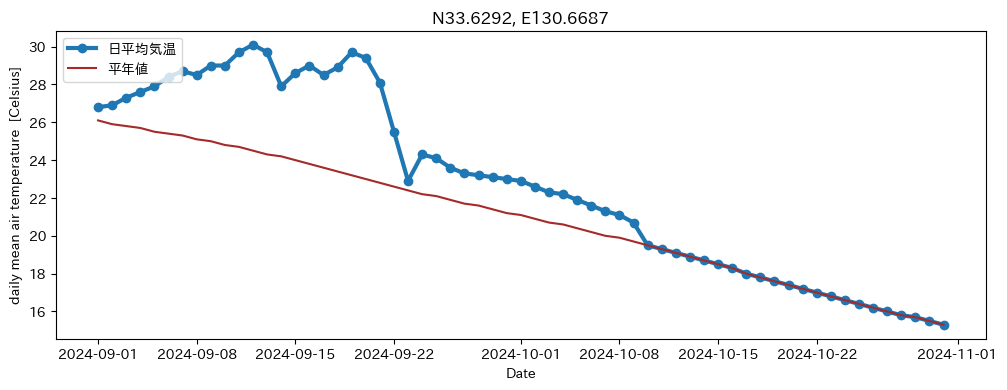

In [76]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
初め= '2024-09-01' # @param {type:"date"}
終わり = '2024-10-31' # @param {type:"date"}
itsu= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###平年値を取得するかどうか

#@markdown ※平年値がない値を選択するとエラーになります
平年値 = True # @param {type:"boolean"}
cli=平年値

# 設定に基づき気象データを取得
if cli==True:
  #設定に基づき気象データを取得
  data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  #設定に基づき平年値を取得
  data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,cli=True,namuni=True)  # 戻り値は6個になる
  Tn = data[:,0,0]   #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      ref=Tn,
      filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')
else:
  data, tim, lat, lon,nam,uni = amd.GetMetData(nani, itsu, doko,namuni=True)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')

### 7.2 メッシュデータの分布図
　AMD_Tools4に含まれる関数 **mapfig** は、2次元配列のデータをシンプルな分布図として可視化します。

```Python
 AMD_Tools4.mapfig(arr,lat,lon,minmax=None,figsize=None,
               cmap='Spectral_r',figtitle='',barlabel='',
               filename=None,**kwargs)
```
引数(必須)：
* **arr**： 分布図にする２次元配列
* **lat**： 緯度値の配列
* **lon**： 経度値の配列
  
引数(必要なときだけ使用)：<br>
* **minmax**： カラースケールの範囲を指定する場合に2要素リストで[最小値, 最大値] を与える
* **figsize**： 分布図のサイズを指定する場合に、2要素リストで[横サイズ,縦サイズ]を与える
* **cmap**： 配色を指定する場合に、"カラースケール名"を文字列で指定する
* **figtitle**： 図の上に文字を表示する場合に、その文字列を与える
* **barlabel**: カラースケールに文字列を付ける場合に、その文字列を与える
* **filename**： 作画した分布図をPNGファイルで保存する場合に、"文字列.png"を与える。

戻り値：**なし**<br>

#### 例１
　室戸岬を含む広い範囲における2016年1月1日の日平均気温を取得し分布図を描画する。

In [49]:
# 変数に取得条件を設定
nani = 'TMP_mea'
itsu = ['2016-01-01', '2016-01-01']
doko = [33.0, 35.0, 132.0, 136.0]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]

TMP_mea (2, 241, 320) Tile


TMP_mea (1, 120, 80) Tile


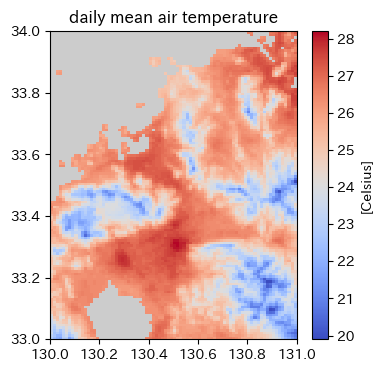

In [72]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
日付= '2024-09-01' # @param {type:"date"}
itsu= [日付, 日付]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
小さいほうの緯度 = 33.0 # @param {type:"number"}
小さいほうの経度 = 130.0 # @param {type:"number"}
大きいほうの緯度 = 34.0 # @param {type:"number"}
大きいほうの経度 = 131.0 # @param {type:"number"}

doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]
amd.mapfig(Ta, lat, lon,
        #minmax=[-10,40],
        figtitle=f'{nam}',
        barlabel=f'[{uni}]',
        filename='t4c72ex2.png',
        cmap='coolwarm')

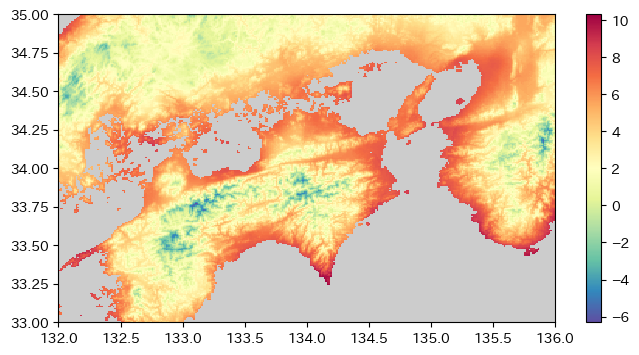

In [50]:
amd.mapfig(Ta, lat, lon)

#### 例２
　同じ気温分布を、異なるカラースケール、異なるカラーマップで可視化するとともに、ファイル保存する。<br>
　関数の引数の括弧の中では、改行を自由に入れることができます。

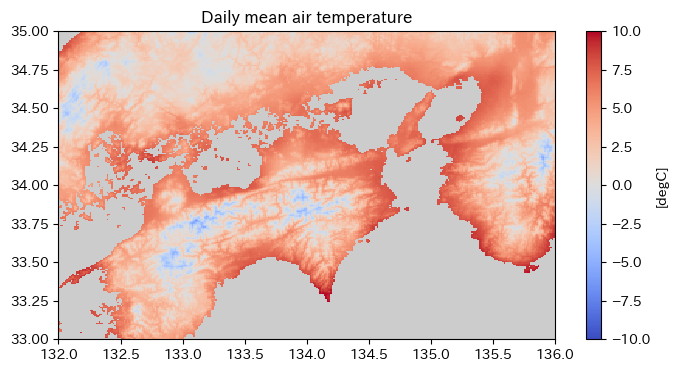

In [51]:
amd.mapfig(Ta, lat, lon, minmax=[-10,10],
        figtitle=f'{nam}',
        barlabel=f'[{uni}]',
        filename='t4c72ex2.png',
        cmap='coolwarm')
# Python では、括弧の中では改行やインデントを自由にできます。

### 7.3 地理院地図へのオーバーレイ
　ライブラリ **AMD_Tools4** が提供する関数 **PutGSI_Map** を用いると、メッシュデータを地理院地図と重ね合わせて表示することができ、結果の詳細な確認が可能です。

　下を実行するとファイルが４つ新規作成されるので、その中の１つ **t4c73.html** をダブルクリックしてください。

In [ ]:
amd.PutGSI_Map(Ta, lat, lon, filename='t4c73')

　４つのファイルがあれば、PythonやJupyterがインストールされていなくとも、インターネットに接続されたPCでは、同じ図を表示させることが可能なので、結果の共有にも便利です。

```Python
AMD_Tools4.PutGSI_Map(data, lat, lon, label=None, cmapstr=None,
                      minmax=None, filename="result", outdir=".")
```
引数(必須)：<br>
* **data**：分布を表示させる２次元配列
* **lat**：緯度の１次元配列
* **lon**：経度の１次元配列

引数(必要なときだけ使用)：<br>
* **label**：凡例のタイトルの文字列
* **cmapstr**：カラーマップを指定（詳細は後述）
* **minmax**：カラースケールを指定（[min,max]のリスト）
* **filename**：出力ファイル名
* **outdir**：出力フォルダ名

カラーマップについて：<br>
　カラーマップには名称があるのでこれを文字列で("で囲んで)指定します。カラーサンプルは下記URLを参照のこと。<br>
https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html<br>
　なお、色の順序を反転させたい場合は、"rainbow_r" のよう名称の後ろに"_r"を付加します。

注意：<br>
　この関数は、numpy.datetime64[D]型(日時を表現するための数値)の配列も表示することができるので、日付の分布図を描画できます。但し、等値色の塗り方はメッシュ単位ではなく、メッシュ中心点の値を等高線で結ぶような描画になります。<br>
　また、オプション引数minmaxで配色の下限と上限を日付で指定する場合は、下記のようにして日付値を指定してください(datetimeオブジェクトで指定すると誤作動します)。<br>
```Python
    minmax = [np.datetime64('2018-08-25','D'),np.datetime64('2018-09-05','D')]
```

## 8 時別データの取得
メッシュ農業気象データでは時別値も公開しています。<br>
現在利用可能な気象要素は、気温（TMP）、相対湿度（RH）、下向き長波放射（DLR）の３種類です。平年値の節でも紹介したリンクに、時別値データの搭載期間について説明があるので参照してください。

https://amu.rd.naro.go.jp/wiki_open/doku.php?id=about#多彩な気象要素が用意されています

　時別値の取得には **GetMetDataHourly** 関数を使います。日別データの取得関数とほぼ同じ要領で使用できます。<br>
**GetMetDataHourly** 関数では、
- 取得する日時の範囲指定には、['2023-01-25T03, '2023-01-25T21'] のように **日付の後にTを付けて、時を２桁で記入**します。
- 時刻は 1時を示す **T01** から **T24** まで、一桁の場合はゼロで埋めた二桁の数値で指定します。
- 取得する時間の範囲に日付だけにすることも可能です。この場合、期間の最初の日の01時から、期間の最終日の24時までを取得します。


#### 例
　室戸岬の最突端の時別気温を2016年6月について取得し折れ線グラフにします。

In [ ]:
# 基本的な設定
nani = 'TMP'  # '気温' を指定
itsu = ['2016-06-01T01', '2016-06-30T24'] # 期間を指定。時刻まで指定したい場合は日付の後に T01-T24 を付ける。
doko = [ 33.3375, 33.3375,  132.00626, 132.00626 ]

# 気象データの取得
data, timh, lat, lon, nam, uni = amd.GetMetDataHourly(nani, itsu, doko, namuni=True)

TMP (721, 1, 1) Hourly


　上のスクリプトを実行し、「TMP (721, 1, 1)」と表示されたらデータは正常に取得されています。以下でデータのサイズも確認してください。

In [ ]:
data.shape

(720, 1, 1)

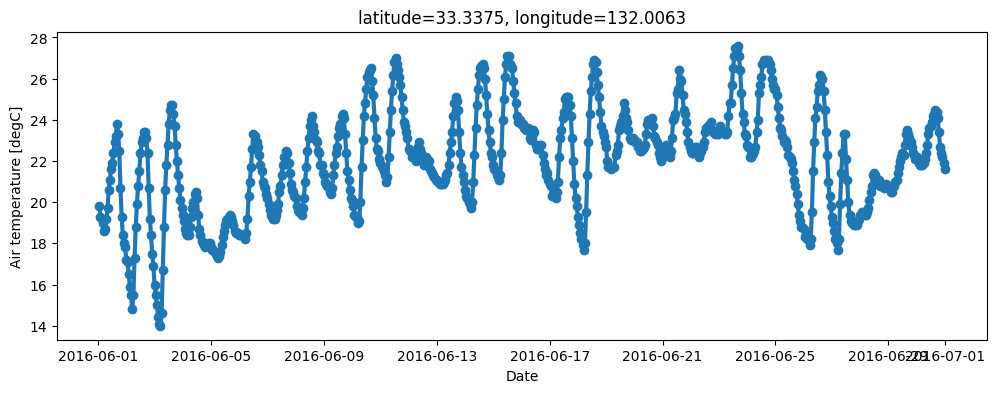

In [ ]:
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(timh,Th,
         title=f'latitude={lat_sc:.4f}, longitude={lon_sc:.4f}',
         ylabel=f'{nam} [{uni}]')

## 9 温暖化シナリオデータの取得
メッシュ農業気象データでは全球気候モデルを用いた温暖化シナリオデータ(日別値)も３次メッシュで公開しています。<br>
利用可能な全球気候モデル、温暖化シナリオ、予測期間については、以下で確認してください。<br>
https://amu.rd.naro.go.jp/wiki_open/doku.php?id=scenalio

　シナリオデータの取得には **GetSceData** 関数を使います。モデルとシナリオを引数で指定する必要がありますが、それ以外は通常の日別データの取得関数と同じです。なお、温暖化シナリオデータには、平年値はありません。

```Python
AMD_Tools4.GetSceData(nani, itsu, doko, model, scenam,
                      namuni=False, url='https://amd.rd.naro.go.jp/opendap/AMS')
```
引数(必須)：<br>
* **nani**： 気象要素記号で、'TMP_mea'などの文字列で与える
* **itsu**： 取得するデータの時間範囲で、['2080-05-01', '2080-05-31'] のように文字列の2要素リストで与える。特定の日のデータを取得するときは二カ所に同じ日付を与える。
* **doko**： 取得するデータの緯度と経度の範囲で、[36.0, 40.0, 130.0, 135.0] のように緯度経度の順で範囲の最小値と最大値を指定する。特定メッシュのデータを取得するときは、それぞれの最小値と最大値に同じ値を与える。
* **model**：気候モデルの記号で、'MIROC5'などの文字列で与える
* **scenam**：排出シナリオ等の記号で、'RCP8.5'などの文字列で与える
  
引数(必要なときだけ使用)：<br>
* **namuni**: namuni=True とすると、関数の戻り値に、気象要素の正式名称と単位が追加される。
* **url**: 気象データを取り出す場所を指定する。省略した場合は**農研機構のデータ配信サーバー** からデータを取得する。

戻り値：<br>
* **第1戻り値**： 指定した気象要素の３次元(時刻、緯度、経度) 配列。範囲の指定の仕方にかかわらず常に３次元となる。
* **第2戻り値**： 切り出した気象データの緯度の１次元配列。値は浮動小数。
* **第3戻り値**： 切り出した気象データの経度の１次元配列。値は浮動小数。
* **第4戻り値**(引数に namuni=True を加えたときのみ)： 気象要素の正式名。文字列。
* **第5戻り値**(引数に namuni=True を加えたときのみ)： 気象要素の単位。文字列。

#### 例
　全球気候モデル **MIROC5** と、シナリオ **RCP8.5** で予測された茨城県つくば市内（舘野）における2100年の日最高気温のグラフを描く。

Cli_TMP_max (365, 1, 1) Tile
TMP_max (365, 1, 1) Tile MIROC5 RCP8.5)


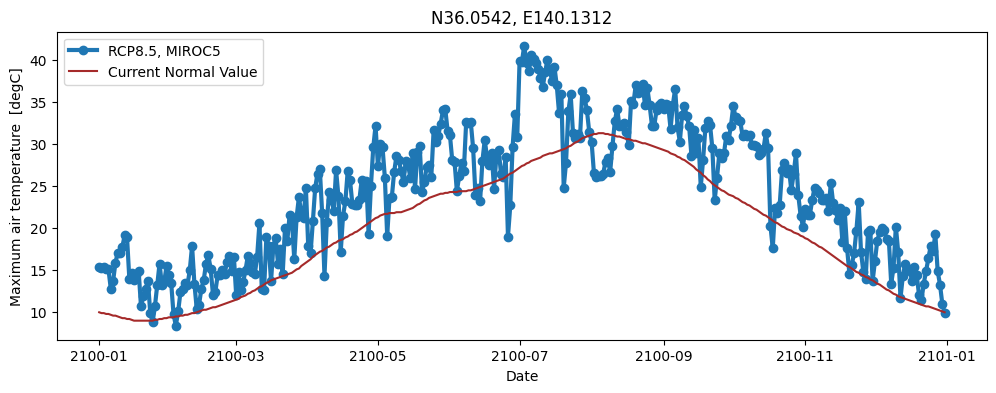

In [ ]:
# 気象データの取得
model = 'MIROC5'
scenario = 'RCP8.5'
nani = 'TMP_max'
doko = [ 36.0567, 36.0567, 140.1250, 140.1250 ]  #舘野

# 現在の平年値(平年値2020)の取得
itsu = ['2021-01-01', '2021-12-31']
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko, cli=True)
Tmax = data[:,0,0]

# シナリオデータの取得
itsu = ['2100-01-01', '2100-12-31']
data, tim, lat, lon, nam, uni = amd.GetSceData(nani, itsu, doko, model, scenario, namuni=True)
Tsmax = data[:,0,0]

# 折れ線グラフ
amd.linefig(tim, Tsmax,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=f'{scenario}, {model}',
      ref=Tmax,
      llabelref='Current Normal Value')

##引用
このノートブックには[農研機構メッシュ農業気象データThe Agro-Meteorological Grid Square Data, NARO大野ら、2016](https://amu.rd.naro.go.jp/)を利用した。

##文献
● 大野宏之、佐々木華織、大原源二、中園　江、2016：実況値と数値予報、平年値を組み合わせたメッシュ気温・降水量データの作成. 生物と気象、16、71-79．

● 佐々木華織、西森基貴、根本　学、2022：メッシュ農業気象データ利用マニュアルVer.5．農研機構、77pp．